In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn import preprocessing, model_selection, linear_model, tree, ensemble, metrics, feature_selection, neighbors
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from scipy import stats
from xgboost import XGBRegressor

In [3]:
!pip install xgboost


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
RANDOM_STATE = 1234
np.random.seed = RANDOM_STATE

# Uvod

Baza podataka "Black Friday Sales" sadrži podatke o kupovini u toku Crnog Petka. To je dan nakon Dana zahvalnosti i tada su veliki popusti i rasprodaje garderobe, elektronskih uređaja, itd. Veliki broj ljudi ide u kupovinu i troši više novca nego inače.

Analizom ponašanja potrošača, odnosno proučavanjem uticaja faktora kao što su starost, pol i lokacija na potrošačke navike, omogućava kompanijama da bolje prilagode svoje marketinške strategije. Predviđanjem iznosa kupovina one mogu bolje da upravljaju zalihama i da odrede ciljane promocije tokom budućih rasprodaja.
To cemo postici primenom mašinskog učenja. Glavni cilj je da kreiramo što bolji model na osnovu kog ćemo izvršiti predviđanje.

# Učitavanje podataka

In [5]:
data = pd.read_csv('Black Friday Dataset.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [7]:
data.shape

(550068, 12)

Baza sadrži informacije o preko 500.000 kupaca. Ona ima 12 kolona, koje predstavljaju podatke o kupcima, dakle na osnovu toga stičemo uvid u to ko kupuje i odakle dolazi. Zatim, imamo informacije o kategoriji proizvoda, i na kraju imamo kolonu 'Purchase' koja predstavlja iznos koji su kupci potrošili tokom rasprodaje.

# Preprocesiranje

In [8]:
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


Za početak izbacićemo kolone ID kupaca i proizvoda jer one nemaju nikakvog uticaja na ishod kupovine.

In [9]:
data.drop(['User_ID','Product_ID'], axis=1, inplace=True)

U kolonama 'Age' i 'Stay_In_Current_City_Years' se javljaju plusevi koje ćemo ukloniti.

In [10]:
data['Age'] = data['Age'].str.strip('+')
data['Stay_In_Current_City_Years'] = data['Stay_In_Current_City_Years'].str.strip('+')

### Nedostajuće vrednosti

In [11]:
pd.DataFrame({'missing_values': data.isnull().sum(), 'missing_values_percent': data.isnull().sum() / data.shape[0]*100})

,missing_values,missing_values_percent
Gender,0,0.000000
Age,0,0.000000
Occupation,0,0.000000
City_Category,0,0.000000
Stay_In_Current_City_Years,0,0.000000
Marital_Status,0,0.000000
Product_Category_1,0,0.000000
Product_Category_2,173638,31.566643
Product_Category_3,383247,69.672659
Purchase,0,0.000000


Kako imamo dosta nedostajućih podataka u koloni Product_Category_3 pa ćemo je izbaciti. Dok u koloni Product_Category_2 nedostajuće vrednosti dopunjavamo medijanom.

In [12]:
data.drop('Product_Category_3', axis=1, inplace=True)

In [13]:
data['Product_Category_2'].fillna(data['Product_Category_2'].median(), inplace = True)

C:\Users\HP\AppData\Local\Temp\ipykernel_3796\610629193.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Product_Category_2'].fillna(data['Product_Category_2'].median(), inplace = True)


In [14]:
data.isnull().sum()

Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Purchase                      0
dtype: int64

### Kodiranje kategoričkih promenljivih

In [15]:
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])  
#data['Age'] = le.fit_transform(data['Age'])        
data['City_Category'] = le.fit_transform(data['City_Category'])
data['Stay_In_Current_City_Years'] = pd.to_numeric(data.Stay_In_Current_City_Years)

In [16]:
data.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase
0,0,0-17,10,0,2,0,3,9.0,8370
1,0,0-17,10,0,2,0,1,6.0,15200
2,0,0-17,10,0,2,0,12,9.0,1422
3,0,0-17,10,0,2,0,12,14.0,1057
4,1,55,16,2,4,0,8,9.0,7969


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Gender                      550068 non-null  int64  
 1   Age                         550068 non-null  object 
 2   Occupation                  550068 non-null  int64  
 3   City_Category               550068 non-null  int64  
 4   Stay_In_Current_City_Years  550068 non-null  int64  
 5   Marital_Status              550068 non-null  int64  
 6   Product_Category_1          550068 non-null  int64  
 7   Product_Category_2          550068 non-null  float64
 8   Purchase                    550068 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 37.8+ MB


#

In [18]:
data.describe()

,Gender,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase
count,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000
mean,0.753105,8.076707,1.042640,1.858418,0.409653,5.404270,9.576434,9263.968713
std,0.431205,6.522660,0.760211,1.289443,0.491770,3.936211,4.226025,5023.065394
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,12.000000
25%,1.000000,2.000000,0.000000,1.000000,0.000000,1.000000,8.000000,5823.000000
50%,1.000000,7.000000,1.000000,2.000000,0.000000,5.000000,9.000000,8047.000000
75%,1.000000,14.000000,2.000000,3.000000,1.000000,8.000000,14.000000,12054.000000
max,1.000000,20.000000,2.000000,4.000000,1.000000,20.000000,18.000000,23961.000000


<Axes: >

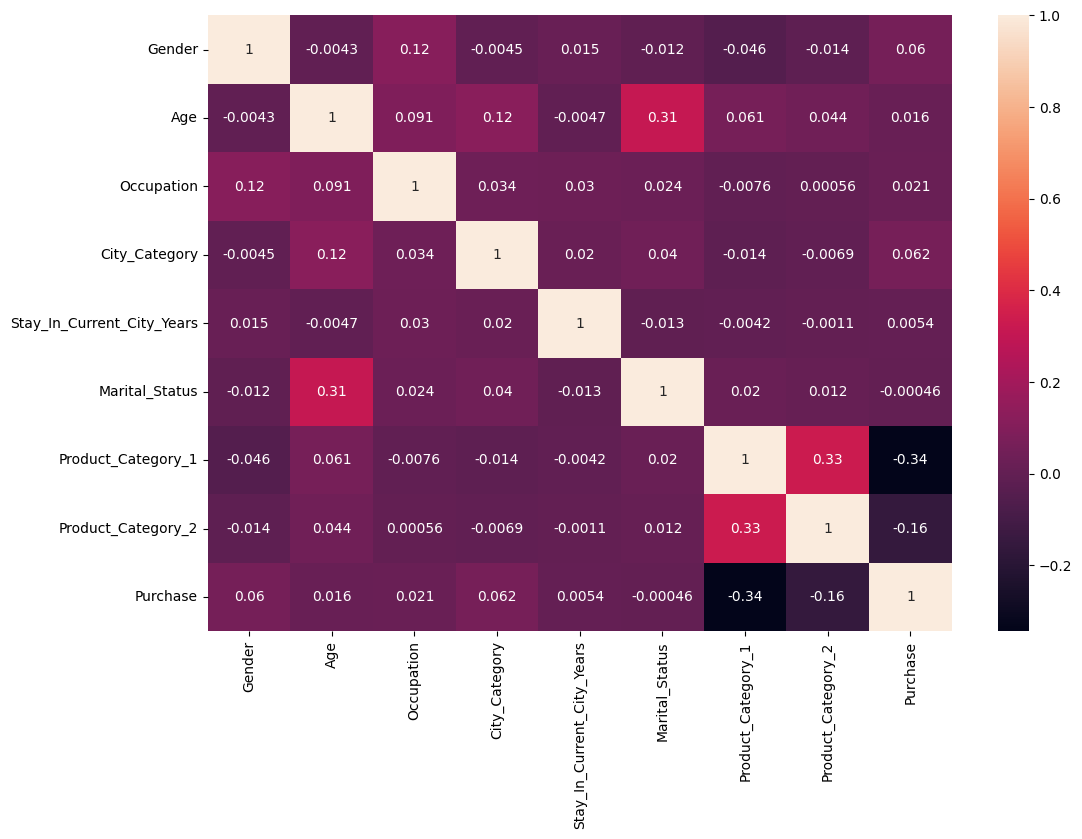

In [100]:
plt.figure(figsize=(12, 8))

sns.heatmap(
    data.corr(),
    annot=True
)

# Vizuelizacija podataka

array([[<Axes: title={'center': 'Gender'}>,
        <Axes: title={'center': 'Occupation'}>,
        <Axes: title={'center': 'City_Category'}>],
       [<Axes: title={'center': 'Stay_In_Current_City_Years'}>,
        <Axes: title={'center': 'Marital_Status'}>,
        <Axes: title={'center': 'Product_Category_1'}>],
       [<Axes: title={'center': 'Product_Category_2'}>,
        <Axes: title={'center': 'Purchase'}>, <Axes: >]], dtype=object)

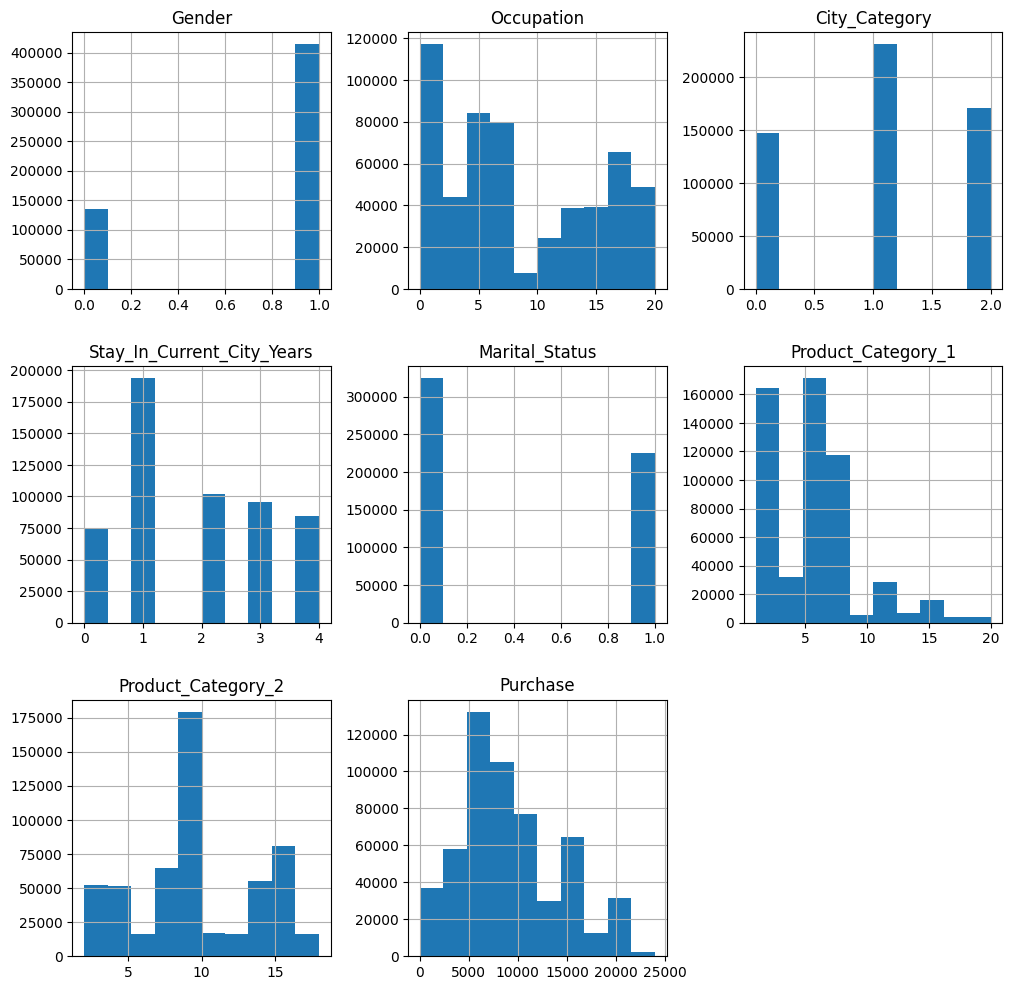

In [19]:
data.hist(figsize=(12,12))

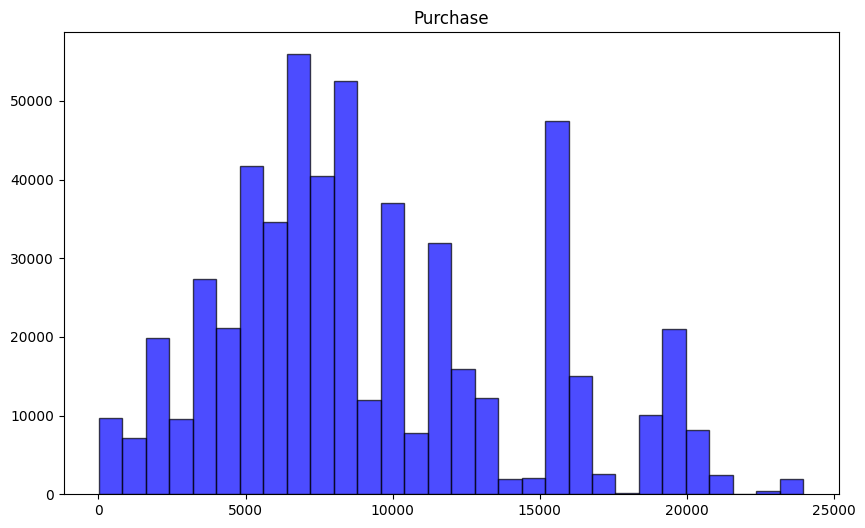

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(data['Purchase'], bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Purchase')
plt.show() 

In [21]:
stat, p = stats.shapiro(data['Purchase'])
print(f'p-vrednost = {p}')

p-vrednost = 2.9829518736335884e-122


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 550068.
  res = hypotest_fun_out(*samples, **kwds)


Sa grafika moze delovati da vrednost potrosenog novca prati normalnu raspodelu, ali videmo da nam autlajeri narusavaju tu raspodelu. Zaista, na osnovu Shapiro-Wilk testa o normalnosti odbacuje se pretpostavka da podaci prate normalnu raspodelu, zbog male p-vrednosti.

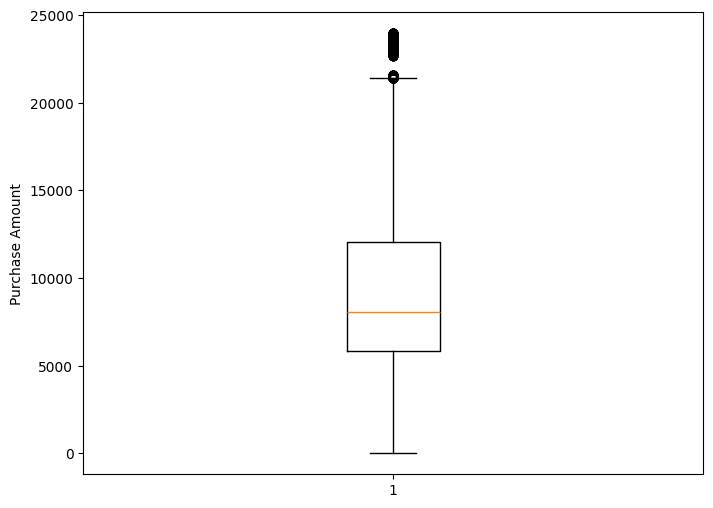

In [22]:
plt.figure(figsize=(8, 6))
plt.boxplot(data['Purchase'])
plt.ylabel('Purchase Amount')
plt.show()

Na box plotu se jasno i uocavaju izrazito velike vrednosti potrosenog novca.

# Prosecna potrosnja po polu

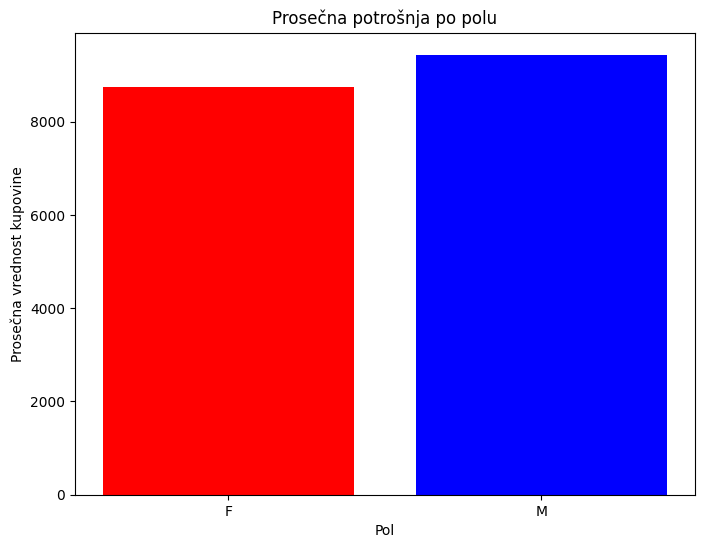

In [23]:
plt.figure(figsize=(8, 6))
plt.bar(['F', 'M'], data.groupby('Gender')['Purchase'].mean().values, color=['red', 'blue'])
plt.title('Prosečna potrošnja po polu')
plt.xlabel('Pol')
plt.ylabel('Prosečna vrednost kupovine')
plt.show()

# Prosecna potrosnja po gradu

In [24]:
data.groupby('City_Category')['Purchase'].mean()

City_Category
0    8911.939216
1    9151.300563
2    9719.920993
Name: Purchase, dtype: float64

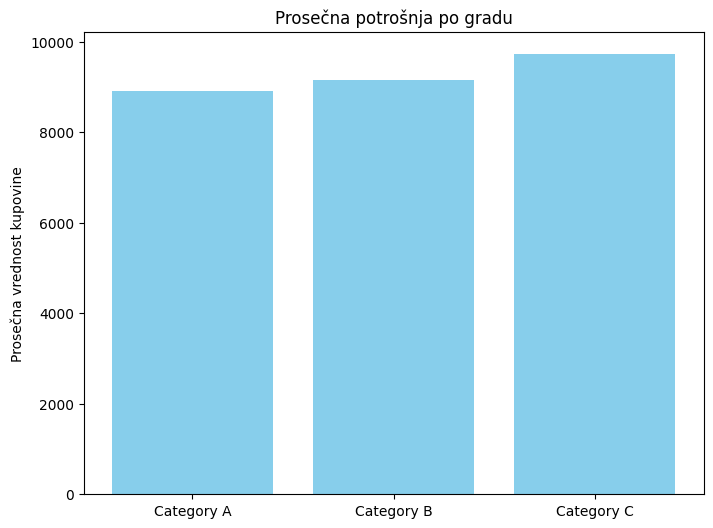

In [25]:
plt.figure(figsize=(8, 6))
plt.bar(['Category A', 'Category B', 'Category C'], data.groupby('City_Category')['Purchase'].mean().values, color='skyblue')
plt.title('Prosečna potrošnja po gradu')
plt.ylabel('Prosečna vrednost kupovine')
plt.show()

# Prosecna potrosnja po starosnim grupama

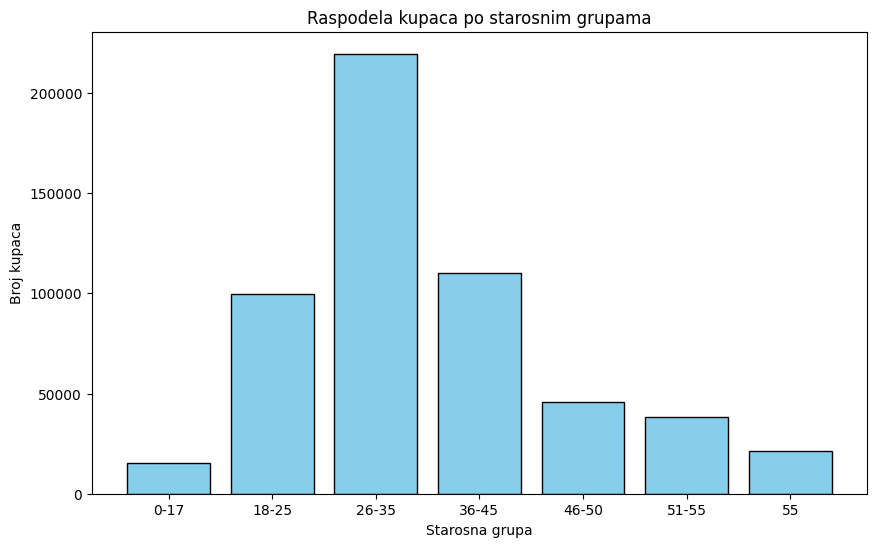

In [26]:
plt.figure(figsize=(10, 6))
plt.bar(data['Age'].value_counts().sort_index().index, data['Age'].value_counts().sort_index().values, color='skyblue', edgecolor='black')
plt.title('Raspodela kupaca po starosnim grupama')
plt.xlabel('Starosna grupa')
plt.ylabel('Broj kupaca')
plt.xticks(rotation=0)
plt.show()

In [27]:
data.groupby('Age')['Purchase'].mean().sort_index().reset_index()

,Age,Purchase
0,0-17,8933.464640
1,18-25,9169.663606
2,26-35,9252.690633
3,36-45,9331.350695
4,46-50,9208.625697
5,51-55,9534.808031
6,55,9336.280459


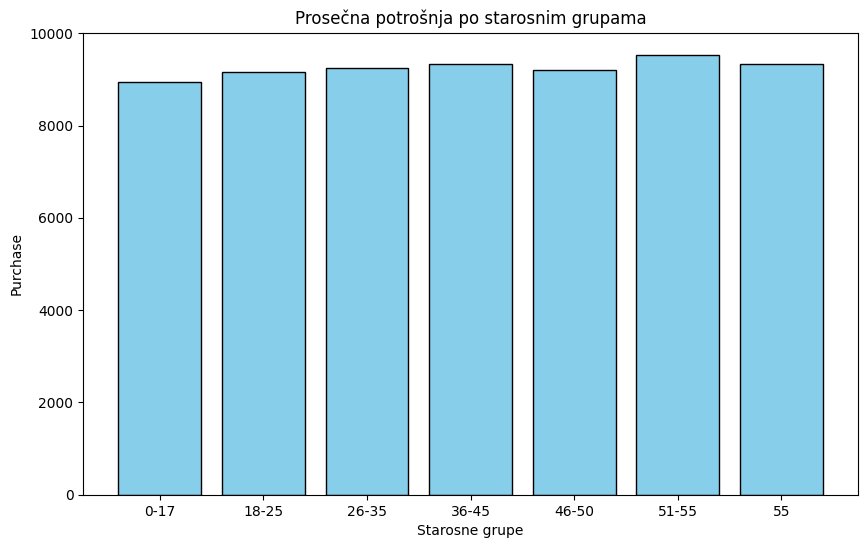

In [28]:
plt.figure(figsize=(10, 6))
plt.bar(data.groupby('Age')['Purchase'].mean().sort_index().reset_index()['Age'], data.groupby('Age')['Purchase'].mean().sort_index().reset_index()['Purchase'], color='skyblue', edgecolor='black')
plt.xlabel('Starosne grupe')
plt.ylabel('Purchase')
plt.title('Prosečna potrošnja po starosnim grupama')
plt.xticks(rotation=0)
plt.show()

# Prosecna potrosnja po kategorijama prozivoda

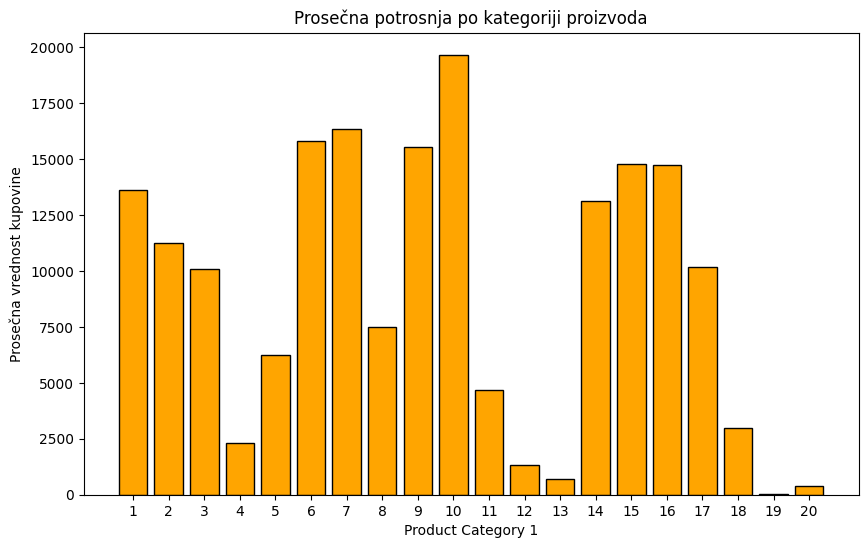

In [29]:
plt.figure(figsize=(10, 6))
plt.bar(data.groupby('Product_Category_1')['Purchase'].mean().reset_index()['Product_Category_1'].astype(str), data.groupby('Product_Category_1')['Purchase'].mean().reset_index()['Purchase'], color='orange', edgecolor='black')
plt.title('Prosečna potrosnja po kategoriji proizvoda')
plt.xlabel('Product Category 1')
plt.ylabel('Prosečna vrednost kupovine')
plt.show()

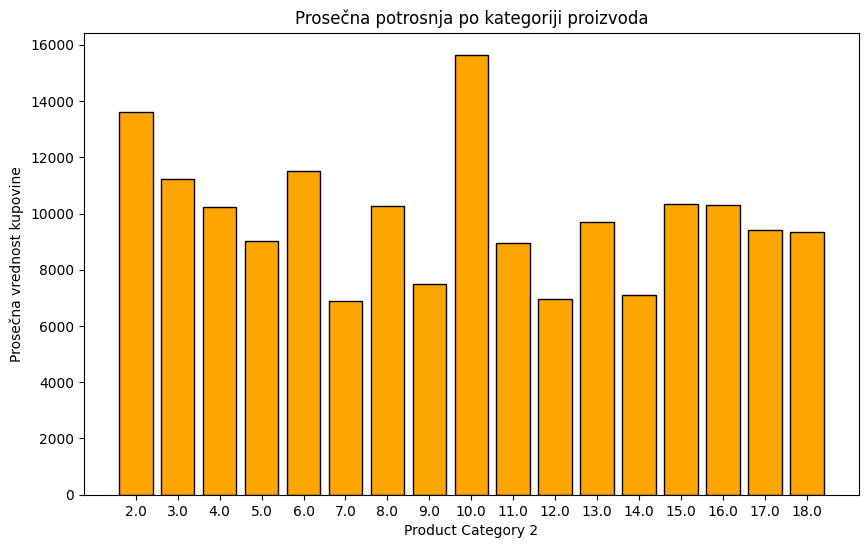

In [30]:
plt.figure(figsize=(10, 6))
plt.bar(data.groupby('Product_Category_2')['Purchase'].mean().reset_index()['Product_Category_2'].astype(str), data.groupby('Product_Category_2')['Purchase'].mean().reset_index()['Purchase'], color='orange', edgecolor='black')
plt.title('Prosečna potrosnja po kategoriji proizvoda')
plt.xlabel('Product Category 2')
plt.ylabel('Prosečna vrednost kupovine')
plt.show()

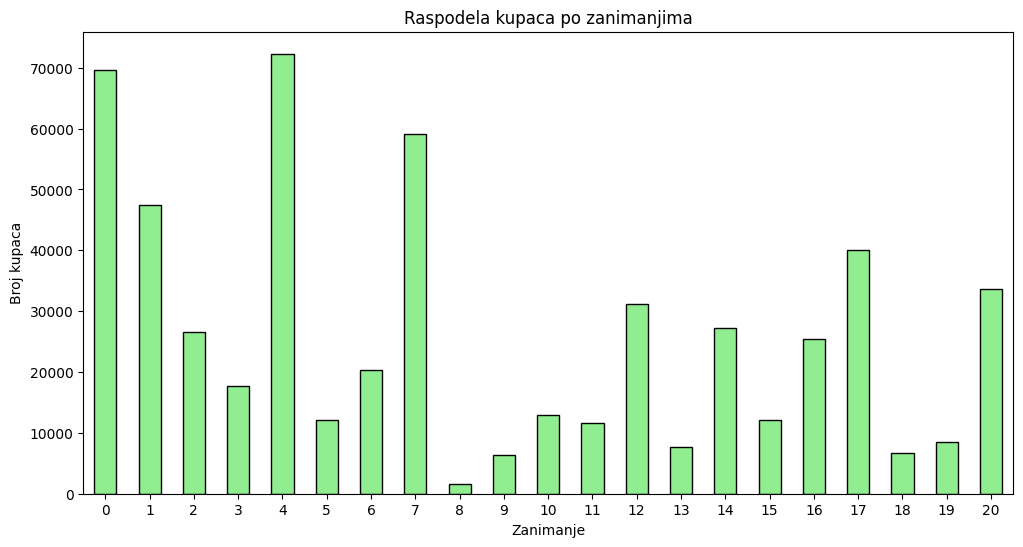

In [31]:
plt.figure(figsize=(12, 6))
data['Occupation'].value_counts().sort_index().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Raspodela kupaca po zanimanjima')
plt.xlabel('Zanimanje')
plt.ylabel('Broj kupaca')
plt.xticks(rotation=0)
plt.show()

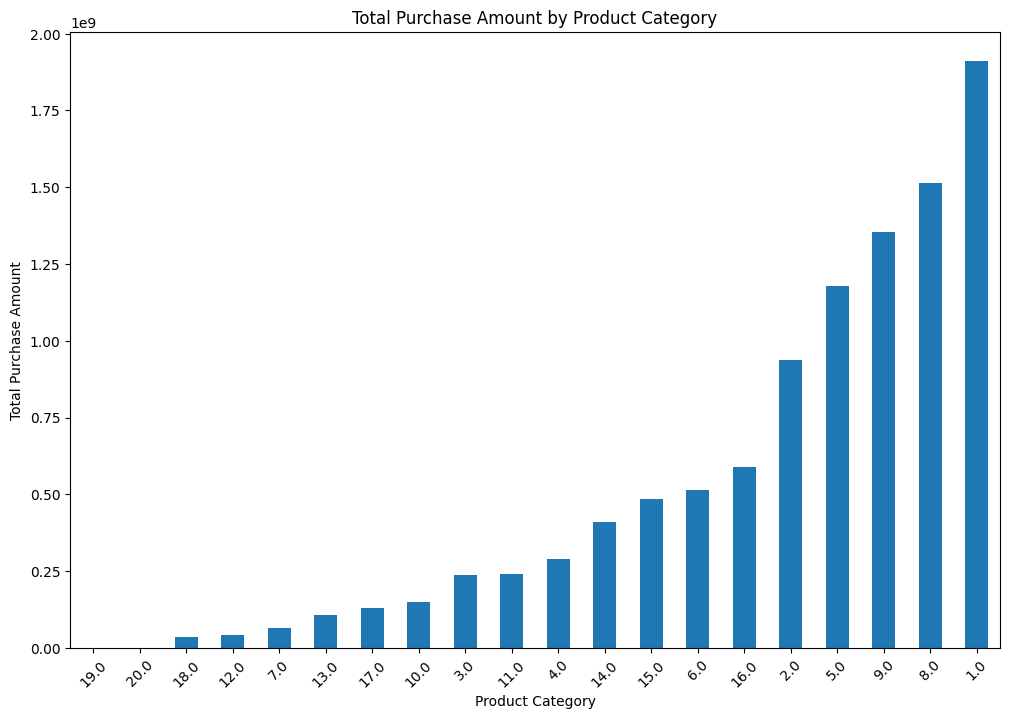

In [32]:
category_purchase = data[['Product_Category_1', 'Product_Category_2', 'Purchase']].copy()
category_purchase = category_purchase.melt(id_vars='Purchase', var_name='Category', value_name='Product_Category')
category_purchase = category_purchase.groupby('Product_Category')['Purchase'].sum().sort_values()
 
plt.figure(figsize=(12, 8))
category_purchase.plot(kind='bar')
plt.title('Total Purchase Amount by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Purchase Amount')
plt.xticks(rotation=45)
plt.show()

In [33]:
#vidimo koje su kategorije proizvoda najtrazenije tokom crnog petka

# Kreiranje modela

In [34]:
data['Age'] = le.fit_transform(data['Age'])  

In [35]:
x = data.drop('Purchase', axis=1)
y = data['Purchase']

In [36]:
x.shape, y.shape

((550068, 8), (550068,))

## Podela podataka

In [37]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.33, random_state=RANDOM_STATE)

## Skaliranje podataka

In [38]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_train, y_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

## Kreiranje modela

In [39]:
lr = linear_model.LinearRegression()
dt = tree.DecisionTreeRegressor(random_state=RANDOM_STATE)
rf = ensemble.RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
xgboost = XGBRegressor(n_estimators=100, random_state=RANDOM_STATE)

In [40]:
lr.fit(x_train, y_train)
dt.fit(x_train, y_train)
rf.fit(x_train, y_train)
xgboost.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=1234, ...)

In [41]:
def evaluate_model(model, x_test, y_test):
    y_predicted = model.predict(x_test)
    mae = metrics.mean_absolute_error(y_test, y_predicted)
    mse = metrics.mean_squared_error(y_test, y_predicted)    
    r2 = metrics.r2_score(y_test, y_predicted)    
    return mae, mse, r2

In [42]:
results = {
    'Model': ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'XGBoost Regressor'],
    'MAE': [],
    'MSE': [],
    'R² Score': []
}

models = [lr, dt, rf, xgboost]

for model in models:
    mae, mse, r2 = evaluate_model(model, x_test, y_test)
    results['MAE'].append(mae)
    results['MSE'].append(mse)
    results['R² Score'].append(r2)

In [43]:
results_df = pd.DataFrame(results)
print(results_df)

                     Model          MAE           MSE  R² Score
0        Linear Regression  3586.159923  2.195283e+07  0.126190
1  Decision Tree Regressor  2277.618966  1.007100e+07  0.599134
2  Random Forest Regressor  2206.251497  9.136449e+06  0.636333
3        XGBoost Regressor  2177.253269  8.504432e+06  0.661490


<Axes: title={'center': 'Model Coefficients'}>

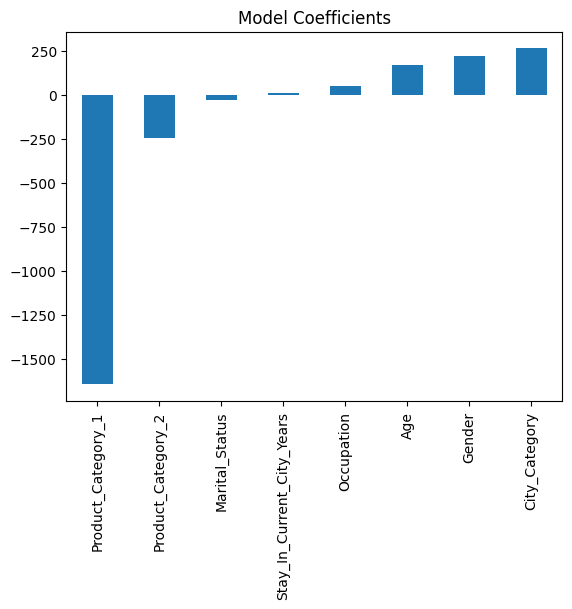

In [44]:
coef = pd.Series(lr.coef_, x.columns).sort_values()
coef.plot(kind='bar', title='Model Coefficients')

<Axes: title={'center': 'Feature Importance'}>

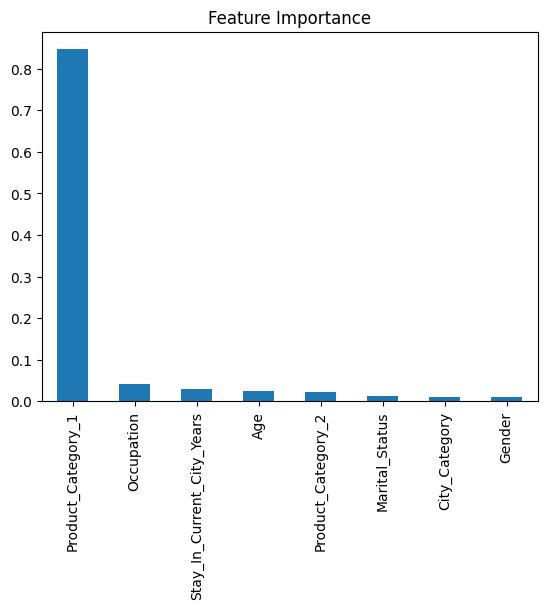

In [45]:
features = pd.Series(dt.feature_importances_, x.columns).sort_values(ascending=False)
features.plot(kind='bar', title='Feature Importance')

<Axes: title={'center': 'Feature Importance'}>

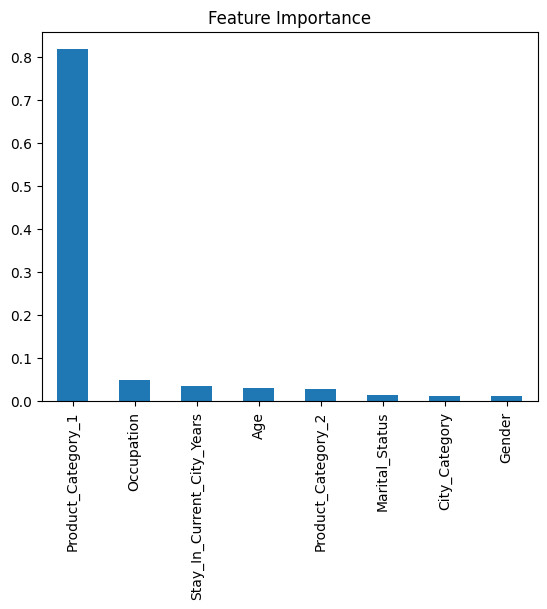

In [46]:
features = pd.Series(rf.feature_importances_, x.columns).sort_values(ascending=False)
features.plot(kind='bar', title='Feature Importance')

# Linearna Regresija

In [47]:
lr = linear_model.LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [48]:
lr.intercept_, lr.coef_

(np.float64(9265.055241558019),
 array([  223.97838414,   170.32675196,    53.23940508,   266.09733585,
           11.24954877,   -27.39745948, -1643.98066309,  -240.74944763]))

In [49]:
y_predicted = lr.predict(x_test)

In [50]:
mae_lr, mse_lr, r2_lr = metrics.mean_absolute_error(y_test, y_predicted), metrics.mean_squared_error(y_test, y_predicted), metrics.r2_score(y_test, y_predicted)

In [51]:
mae_lr, mse_lr, r2_lr

(np.float64(3586.1599233430106),
 np.float64(21952825.254035693),
 0.12618985774111646)

## Log transformacija

Kako raspodela ciljne promenljive nije normalna, probaćemo logaritmovanjem da podatke približimo normalnoj rapodeli. Iz razloga što linearni modeli pretpostavljaju da su odstupanja (greske)(razlike između stvarnih i predviđenih vrednosti) u podacima normalno raspodeljena. Logaritmovanje smanjuje uticaj autlajera.

In [52]:
y_log = np.log(data['Purchase'] + 1)
x = data.drop(['Purchase'], axis=1)

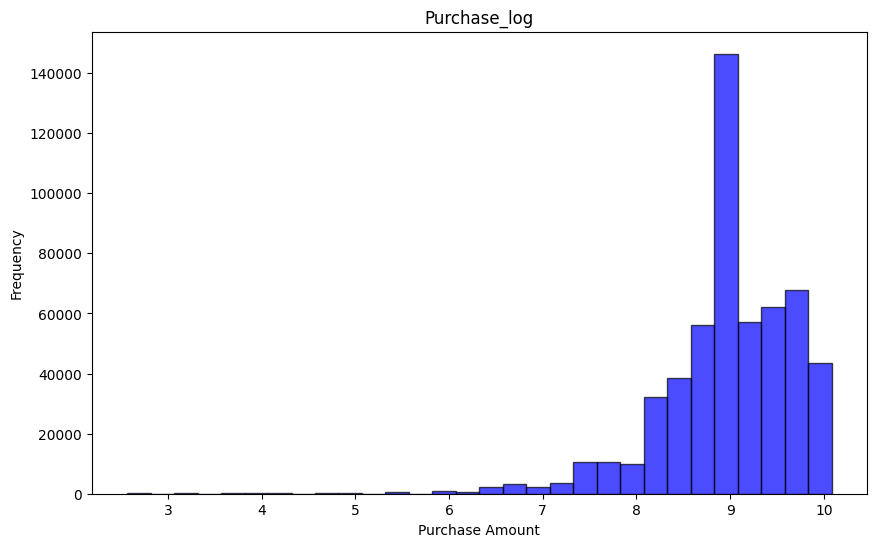

In [53]:
plt.figure(figsize=(10, 6))
plt.hist(np.log(data['Purchase'] + 1), bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Purchase_log')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')
plt.show() 

In [54]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y_log, test_size=0.3, random_state=RANDOM_STATE)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((385047, 8), (165021, 8), (385047,), (165021,))

In [55]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_train, y_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [56]:
lr = linear_model.LinearRegression()
lr.fit(x_train, y_train)

y_predicted_log = lr.predict(x_test)
y_predicted = np.exp(y_predicted_log) - 1

In [57]:
mae_log, mse_log, r2_log = metrics.mean_absolute_error(np.exp(y_test) - 1, y_predicted), metrics.mean_squared_error(np.exp(y_test) - 1, y_predicted), metrics.r2_score(np.exp(y_test) - 1, y_predicted)

In [58]:
mae_log, mse_log, r2_log

(np.float64(3431.2833518994285),
 np.float64(22468709.157503154),
 0.10545699661759445)

## Rekurzivna eliminacija atributa

In [59]:
y = data['Purchase']
x = data.drop(['Purchase'], axis=1)
x.head(), y.head()

(   Gender  Age  Occupation  City_Category  Stay_In_Current_City_Years  \
 0       0    0          10              0                           2   
 1       0    0          10              0                           2   
 2       0    0          10              0                           2   
 3       0    0          10              0                           2   
 4       1    6          16              2                           4   
 
    Marital_Status  Product_Category_1  Product_Category_2  
 0               0                   3                 9.0  
 1               0                   1                 6.0  
 2               0                  12                 9.0  
 3               0                  12                14.0  
 4               0                   8                 9.0  ,
 0     8370
 1    15200
 2     1422
 3     1057
 4     7969
 Name: Purchase, dtype: int64)

In [60]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.33, random_state=RANDOM_STATE)

In [61]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_train, y_train) 
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [62]:
lr = linear_model.LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [63]:
rfe = feature_selection.RFE(lr, n_features_to_select=5, verbose=2)
rfe.fit(x_train, y_train)

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.


RFE(estimator=LinearRegression(), n_features_to_select=5, verbose=2)

In [64]:
rfe.support_

array([ True,  True, False,  True, False, False,  True,  True])

In [65]:
x_train_1 = rfe.transform(x_train)
x_test_1 = rfe.transform(x_test)
x_train_1.shape, x_test_1.shape

((368545, 5), (181523, 5))

In [66]:
lr1 = linear_model.LinearRegression()
lr1.fit(x_train_1, y_train)

LinearRegression()

In [67]:
y_predicted_1 = lr1.predict(x_test_1)
mae_rfe, mse_rfe, r2_rfe = metrics.mean_absolute_error(y_test, y_predicted_1), metrics.mean_squared_error(y_test, y_predicted_1), metrics.r2_score(y_test, y_predicted_1)

In [68]:
mae_rfe, mse_rfe, r2_rfe

(np.float64(3585.852815949364),
 np.float64(21952903.758100204),
 0.12618673296574068)

## Ridge i Lasso regresija

In [69]:
rmodel = linear_model.Ridge(alpha=10) #povecavanjem alpha koeficienti postaju sve manji
rmodel.fit(x_train, y_train)

Ridge(alpha=10)

In [70]:
mae_ridge, mse_ridge, r2_ridge = metrics.mean_absolute_error(y_train, rmodel.predict(x_train)), metrics.mean_squared_error(y_train, rmodel.predict(x_train)), rmodel.score(x_test, y_test)

In [71]:
mae_ridge, mse_ridge, r2_ridge

(np.float64(3597.038884048184),
 np.float64(22081437.15512403),
 0.12618989218990007)

In [72]:
rmodel.intercept_, rmodel.coef_ #beta nije promenjeno ali ovi koeficijenti ostli su malo manji

(np.float64(9265.055241558019),
 array([  223.97432572,   170.31963982,    53.23954472,   266.09148281,
           11.24964015,   -27.39522248, -1643.9329469 ,  -240.75850376]))

In [73]:
lmodel = linear_model.Lasso(alpha=0.1)
lmodel.fit(x_train, y_train)

Lasso(alpha=0.1)

In [74]:
mae_lasso, mse_lasso, r2_lasso = metrics.mean_absolute_error(y_train, lmodel.predict(x_train)), metrics.mean_squared_error(y_train, lmodel.predict(x_train)), lmodel.score(x_test, y_test)

In [75]:
mae_lasso, mse_lasso, r2_lasso

(np.float64(3597.040150501499),
 np.float64(22081437.229407698),
 0.12619033902141863)

In [76]:
lmodel.intercept_, lmodel.coef_ 

(np.float64(9265.055241558019),
 array([  223.89336006,   170.19146571,    53.16421562,   266.0140714 ,
           11.1561132 ,   -27.2544871 , -1643.90856834,  -240.67092911]))

In [77]:
emodel = linear_model.ElasticNet(alpha=0.75, l1_ratio=0.5)
emodel.fit(x_train, y_train)

ElasticNet(alpha=0.75)

In [78]:
mae_en, mse_en, r2_en = metrics.mean_absolute_error(y_train, emodel.predict(x_train)), metrics.mean_squared_error(y_train, emodel.predict(x_train)), emodel.score(x_test, y_test)

In [79]:
mae_en, mse_en, r2_en

(np.float64(3685.3794533559367),
 np.float64(22291686.117454194),
 0.11818260856985163)

In [80]:
emodel.intercept_, emodel.coef_ 

(np.float64(9265.055241558019),
 array([  177.50955631,   106.71656031,    50.11668875,   202.87225063,
           10.97129764,   -10.48666493, -1184.57335395,  -284.19408172]))

## Evaluacija

In [81]:
evaluacija = {
    "Tip": ["lr", "log", "rfe", "ridge", "lasso", "en"],
    "MAE": [mae_lr, mae_log, mae_rfe, mae_ridge, mae_lasso, mae_en],
    "MSE": [mse_lr, mse_log, mse_rfe, mse_ridge, mse_lasso, mse_en],
    "R²": [r2_lr, r2_log, r2_rfe, r2_ridge, r2_lasso, r2_en]
}

df = pd.DataFrame(evaluacija)
df.round(3)

,Tip,MAE,MSE,R²
0,lr,3586.160,2.195283e+07,0.126
1,log,3431.283,2.246871e+07,0.105
2,rfe,3585.853,2.195290e+07,0.126
3,ridge,3597.039,2.208144e+07,0.126
4,lasso,3597.040,2.208144e+07,0.126
5,en,3685.379,2.229169e+07,0.118


# Decision Tree

In [82]:
x = data.drop('Purchase', axis=1)
y = data['Purchase']

## Podela podataka

In [83]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.33, random_state=RANDOM_STATE)

## Skaliranje

In [84]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_train, y_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

## Model

In [85]:
regressor = tree.DecisionTreeRegressor(random_state = RANDOM_STATE)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

In [86]:
metrics.mean_absolute_error(y_test, y_pred), metrics.mean_squared_error(y_test, y_pred), metrics.r2_score(y_test, y_pred)

(np.float64(2277.6189657239634),
 np.float64(10070999.521418128),
 0.5991339874177812)

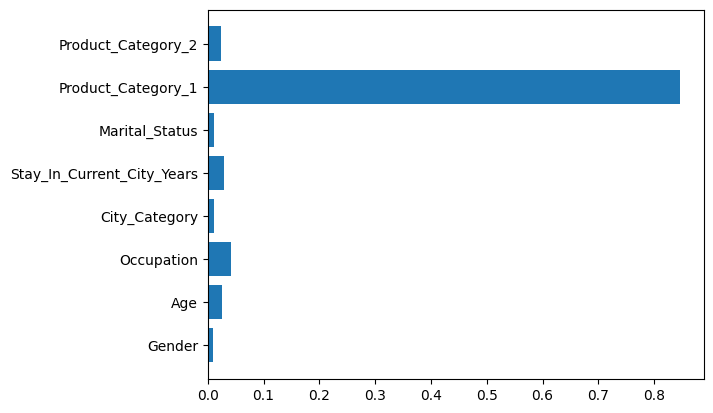

In [87]:
plt.barh(list(x.columns), regressor.feature_importances_)
plt.show()

# Ada boost

In [88]:
model_adaboost= ensemble.AdaBoostRegressor(estimator=tree.DecisionTreeRegressor(max_depth=4), n_estimators=100, random_state=RANDOM_STATE)

In [89]:
model_adaboost.fit(x_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=4),
                  n_estimators=100, random_state=1234)

In [90]:
y_predict_ada = model_adaboost.predict(x_test)

In [91]:
mae_ada, mse_ada, r2_ada = metrics.mean_absolute_error(y_test, y_predict_ada), metrics.mean_squared_error(y_test, y_predict_ada), metrics.r2_score(y_test, y_predict_ada)

In [92]:
mae_ada, mse_ada, r2_ada

(np.float64(2351.670332982223),
 np.float64(9517332.436900374),
 0.6211721491709059)

 Isprobala sam za razlicite vrednosti max_depth, 4 je najbolje, mozda da se ubaci u petlju po max_depth

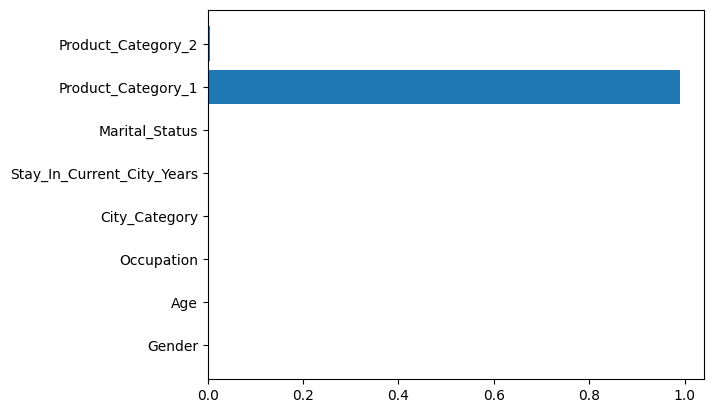

In [93]:
plt.barh(list(x.columns), model_adaboost.feature_importances_)
plt.show()

# XGBoost

In [94]:
from xgboost import plot_importance

In [95]:
model_XGboost = XGBRegressor(n_estimators = 1000, early_stopping_rounds=5)

In [96]:
model_XGboost.fit(x_train, y_train,
             eval_set=[(x_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [97]:

model_XGboost = XGBRegressor(n_estimators=1000, early_stopping_rounds=5)

model_XGboost.fit(x_train, y_train,
                  eval_set=[(x_test, y_test)],  
                  verbose=False)

best_n_estimators = model_XGboost.best_iteration

print(f"The best number of estimators is: {best_n_estimators}")

final_XGboost = XGBRegressor(n_estimators=best_n_estimators)

final_XGboost.fit(x_train, y_train)

y_predict_XG = final_XGboost.predict(x_test)


The best number of estimators is: 168


In [98]:
metrics.mean_absolute_error(y_test, y_predict_XG), metrics.mean_squared_error(y_test, y_predict_XG), metrics.r2_score(y_test, y_predict_XG)

(np.float64(2168.105389032932),
 np.float64(8454506.144036824),
 0.663476824760437)

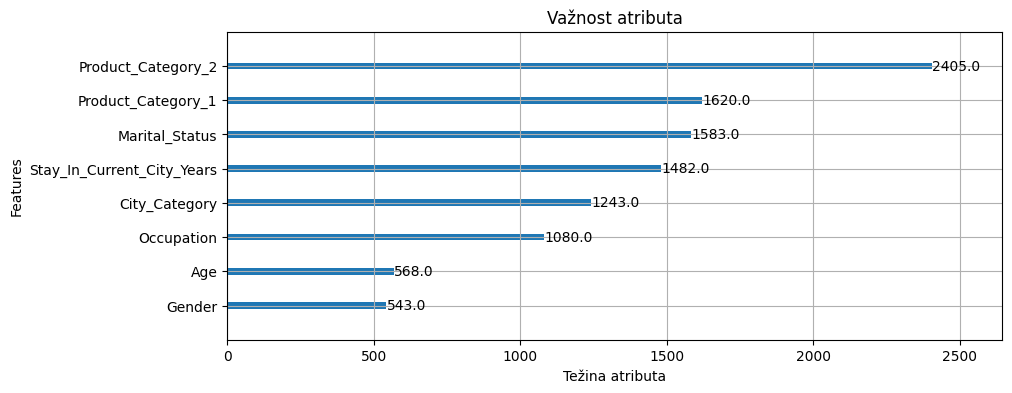

In [99]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 1, 1)

importance = plot_importance(final_XGboost, ax=ax)
num_features = len(importance.get_yticklabels())  

ax.set_yticklabels(data.columns[:num_features])

ax.set_xlabel('Težina atributa')  
ax.set_title('Važnost atributa')   

plt.show()